In [1]:
#Defining Classic Variables

environment_variables = {0: 'road', 1: 'active_zone', 3:'passive_zone'}
theme_variables = {-1: 'naturalistic', -2: 'manicured'}

In [2]:
#Plant variables

class plantSpecies():
    # Note: all plant size currently are diameters of odd values, radius is the number of tiles beyond the center tile
    def __init__(self, species_id, type, height, radius, sun_requirements, attracted_species, fragrant, fruit_bearing, texture) -> None:
        self.species_id = species_id
        self.type = type
        self.height = height
        self.radius = radius
        self.diameter = radius*2 + 1 
        self.sun_requirements = sun_requirements
        self.attracted_species = attracted_species
        self.fragrant = fragrant
        self.fruit_bearing = fruit_bearing
        self.texture = texture


species1 = plantSpecies(100, 'shrub', 0.5, 1, 'low', None, False, False, 'thin')
species2 = plantSpecies(101, 'shrub', 0.75, 2, 'high', 'butterfly', True, True, 'medium')
species3 = plantSpecies(102, 'shrub', 1, 2, 'low', 'bee', False, True, 'coarse')
species4 = plantSpecies(103, 'tree', 10, 2, 'high', None, None, True, None)
species5 = plantSpecies(104, 'tree', 15, 3, 'high', None, None, True, None)
species6 = plantSpecies(105, 'tree', 20, 4, 'high', None, None, True, None)

In [3]:
import numpy as np
# Define Set Environment
def create_grid(type, max_size, shape_size, context_value, shape_value):
    grid = np.full((max_size, max_size), context_value)
    
    start_x_value = (max_size - shape_size[0])//2
    start_y_value = (max_size - shape_size[1])//2
    
    if type == 'square':
        grid[start_y_value:start_y_value+shape_size[1], start_x_value:start_x_value+shape_size[0]] = shape_value

    elif type == 'circle':
        for x in range(max_size):
            for y in range(max_size):
                if (x-start_x_value) **2 + (y - start_y_value)**2 <= shape_size[0]**2:
                    grid[y,x] = shape_value

    elif type == 'rectangle':
        grid[start_y_value:start_y_value+shape_size[1], start_x_value:start_x_value+shape_size[0]] = shape_value

    return grid

In [4]:
env1 = create_grid('square', 100, (80,80), 1, -1)
env2 = create_grid('rectangle', 100, (100, 60), 0, -1)

In [5]:
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt
from itertools import chain

#environment
"""
Current assumptions:
1. only 1 context type per environment
2. only rectangle and square shapes for environment
3. we look at distance from all boundaries with respected to planting
4. only 1 planting plot per environment
"""

class customPlantingEnv(gym.Env):
    def __init__(self, grid, accepted_plants, max_step, max_plants):
        super(customPlantingEnv, self).__init__()

        self.shrub_distance = 6
        self.tree_distance = 10

        self.grid_size= grid.shape
        self.grid = grid
        self.initial_grid = grid.copy()

        self.planting_theme = [value for value in np.unique(grid) if value in [-1, -2]]
        self.planting_context = [value for value in np.unique(grid) if value in [0, 1, 2, 3]]

        self.planting_dist_grid  = self._get_planting_dist_grid()
        self.planting_dist_height = {}
        self.planting_dist_shrub_coord = {}
        self.planting_dist_tree_coord = {}

        self.max_plants = max_plants
        self.successful_plant = 0

        self.plant_coords = self._pad_planted_coordinates([], max_plants)

        self.current_step = 0
        self.max_step = max_step

        self.action_to_plant = {0: species1, 1: species2, 2:species3, 3:species4, 4:species5, 5: species6}
        self.accepted_plant= accepted_plants

        self.action_space = spaces.MultiDiscrete([self.grid_size[0], self.grid_size[1], len(self.action_to_plant)])

        self.observation_space = spaces.Dict(
            {
                "grid": spaces.Box(low=-2, high=105, shape=self.grid_size, dtype=np.int8),
                "plant_coordinates": spaces.Box(low=-1, high=self.grid_size[0], shape=(max_plants, 2), dtype=np.int8)
            }
        )


    def _pad_planted_coordinates(self, plant_coordinates, max_plants):
        padded = np.full((max_plants, 2), -1, dtype=int)  # Initialize with (-1, -1)
        for i, coord in enumerate(plant_coordinates):
            padded[i] = coord
        return padded
    

    def _get_planting_dist_grid(self):
        # Function to get the planting distance 
        # For now assume we look at overall, not just the boundary
        planting_dist_grid = self.initial_grid.copy()
        planting_dist_grid[np.isin(planting_dist_grid, [1, 2, 3])] = 0
        planting_dist_grid[np.isin(planting_dist_grid, [-1, -2])] = 1

        # Calculate distance
        distance_grid = distance_transform_edt(planting_dist_grid)
        distance_grid[distance_grid == 0] = 0
        distance_grid = np.ceil(distance_grid).astype(int)

        return distance_grid


    def reset(self, seed, options):
        self.planting_dist_grid  = self._get_planting_dist_grid()
        self.planting_dist_height = {}
        self.planting_dist_shrub_coord = {}
        self.planting_dist_tree_coord = {}

        self.current_step = 0
        self.successful_plant = 0
        self.plant_coords = self._pad_planted_coordinates([], self.max_plants)
        self.grid = self.initial_grid.copy()

        return self._get_observation(), {}


    def _get_observation(self):
        return {
            'grid': self.grid.astype(np.int8),
            "plant_coordinates": self.plant_coords.astype(np.int8)
        }
    

    def step(self, action):
        x_coord = action[0]
        y_coord = action[1]
        plant_species = self.action_to_plant[int(action[2])]

        self.current_step += 1

        if self.grid[y_coord, x_coord] not in [-1, -2]:
            # Center already overriding existing plant, do not adjust grid as penalty
            return self._get_observation(), -50, self.current_step >= self.max_step, False, {}
        
        # Center on plantable spot, but the radius outside is not
        self.grid, reward1 = self._check_distance(plant_species.type, x_coord, y_coord)
        if reward1 < 0:
            return self._get_observation(), reward1, self.current_step >= self.max_step, False, {}

        self.grid, reward2 = self._check_radius(plant_species.radius, plant_species.species_id, x_coord, y_coord)
        if reward2 < 0:
            return self._get_observation(), reward2, self.current_step >= self.max_step, False, {}

        # Successful Planting
        self.plant_coords[self.successful_plant] = (x_coord, y_coord)
        self.successful_plant += 1
        # Add the coordinate to the lists
        if plant_species.type == 'shrub':
            self.planting_dist_shrub_coord = self._append_to_dict(self.planting_dist_shrub_coord, self.planting_dist_grid[y_coord, x_coord], (x_coord, y_coord), True)
        elif plant_species.type == 'tree':
            self.planting_dist_tree_coord = self._append_to_dict(self.planting_dist_tree_coord, self.planting_dist_grid[y_coord, x_coord], (x_coord, y_coord), True)

        reward = reward1 + reward2

        # Context Type Training
        # Height
        current_distance_from_boundary = self.planting_dist_grid[y_coord, x_coord]
        current_height = plant_species.height
        for current_coord in self.planting_dist_height.keys():
            if current_coord < current_distance_from_boundary:
                all_heights = self.planting_dist_height[current_coord]
                for height in all_heights:
                    if current_height < height:
                        if self.planting_context[0] == 0:
                            reward += 15
                        else:
                            reward -= 15
                    elif current_height > height:
                        if self.planting_context[0] == 0:
                            reward -= 15
                        else:
                            reward += 15
                    else:
                        # tentatively dont want same height
                        reward -= 5 
            
            else:
                break

        # Context Type Training
        # Types
        if plant_species.type == 'shrub' and self.planting_dist_grid[y_coord, x_coord] <= 20:
            if self.planting_context[0] == 0:
                reward -= 15
            else:
                reward += 20

        if plant_species.type == 'tree' and self.planting_dist_grid[y_coord, x_coord] <= 20:
            if self.planting_context[0] == 0:
                reward += 20
            else:
                reward -= 15

        
        self.planting_dist_height = self._append_to_dict(self.planting_dist_height, current_distance_from_boundary, current_height, True)

        # Theme training



        return self._get_observation(), reward, self.current_step >= self.max_step, False, {}


    def _check_radius(self, radius, species_id, x_center, y_center):
        # Check if plant overlaps into other plants / environment
        reward = 0
        new_grid = self.grid.copy()

        for dx in range(-radius, radius+1):
            for dy in range(-radius, radius+1):
                x, y = x_center + dx , y_center + dy
                if dx**2 + dy **2 <= (radius+0.5)**2:
                    if 0 <= x < self.grid_size[0] and 0 <=y < self.grid_size[1]:
                        
                        current_value = self.grid[y, x]
                        # Roll over into unplantable / overlap
                        if current_value not in [-1, -2]:
                            return self.grid, -25
                        
                        else:
                            new_grid[y,x] = species_id
                            reward += 1

        #plant successful
        return new_grid, reward
    

    def _check_distance(self, type, x_coord, y_coord):
        # Check if the center of plant meets the minimmum distance
        all_shrub_coords = list(chain.from_iterable(self.planting_dist_shrub_coord.values()))

        for (x, y) in all_shrub_coords:
            squared_distance = (x_coord - x) ** 2 + (y_coord - y) ** 2
            if squared_distance < self.shrub_distance**2:
                return self.grid, -30
            
        all_tree_coords = list(chain.from_iterable(self.planting_dist_tree_coord.values()))

        for (x, y) in all_tree_coords:
            squared_distance = (x_coord - x) ** 2 + (y_coord - y) ** 2
            if type=='shrub' and squared_distance < self.shrub_distance**2:
                return self.grid, -30
            
            elif type == 'tree' and squared_distance < self.tree_distance**2:
                return self.grid, -30

            else:
                Exception("Invalid size")

        return self.grid, 5


    def _append_to_dict(self, data_dict, key, value, sort):
        key_data = data_dict.get(key, [])
        key_data.append(value)
        data_dict[key] = key_data
        
        if sort:
            sorted_dict = {k: data_dict[k] for k in sorted(data_dict.keys())}
            return sorted_dict

        return data_dict    

    def render(self):
        value_to_color = {
            -2: (93, 185, 130),   # Neutral Green
            -1: (102, 255, 178), # Light Green
            0: (192, 192, 192), # Grey
            1: (102, 51, 0), # Brown
            2: (153, 255, 255), # Cyan
            100: (128, 0, 128), # Purple
            101: (0, 128, 128), # Teal
            102: (255, 255, 0), # Yellow
            103: (255, 153, 51), # Orange
            104: (0, 128, 255), # Blue
            105: (75, 0, 130),  # Indigo
        }

        img = np.zeros((*self.grid_size, 3), dtype=np.uint8)
        for x in range(self.grid_size[0]):
            for y in range(self.grid_size[1]):
                img[x, y] = value_to_color[self.grid[y,x]]


        plt.figure(figsize=(12, 12))
        plt.imshow(img)
        plt.axis('off')

        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color)/255, markersize=10) for color in value_to_color.values()]
        labels = list(value_to_color.keys())
        plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.show()


    def valid_action_mask(self):
        maskx = np.ones(shape=(self.grid_size[0],), dtype=np.int8)
        masky = np.ones(shape=(self.grid_size[1],), dtype=np.int8)
        maskplant = np.ones(shape=(len(self.action_to_plant),), dtype=np.int8)

        # Optionally, mask specific actions based on conditions
        for i in range(len(self.action_to_plant)):
            if self.action_to_plant[i] not in self.accepted_plant:
                maskplant[i] = 0  # Mask this plant action if not allowed

        return np.concatenate((maskx, masky, maskplant))


c:\Users\cheng\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
from sb3_contrib.common.maskable.policies import MaskableMultiInputActorCriticPolicy
from sb3_contrib.common.wrappers import ActionMasker
from sb3_contrib.ppo_mask import MaskablePPO
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv


def mask_fn(env: gym.Env) -> np.ndarray:
    return env.valid_action_mask()

def make_env(grid, accepted_plants, max_steps, max_plants):
    def _init():
        env = customPlantingEnv(grid, accepted_plants, max_steps, max_plants)
        return ActionMasker(env, mask_fn)
    return _init


all_envs = [
    [create_grid('square', 100, (60, 60), 1, -1), [species1, species3, species5, species6], 5000, 1000],
    [create_grid('square', 100, (60, 60), 0, -1), [species1, species2, species4, species5, species6], 5000, 1000]
]


envs = DummyVecEnv([make_env(env[0], env[1], env[2], env[3]) for env in all_envs])

# env1 = customPlantingEnv(create_grid('square', 100, (80,80), 1, -1), [species1, species3, species5, species6], 5000, 1000)
# env = ActionMasker(env1, mask_fn)

In [17]:
model = MaskablePPO("MultiInputPolicy", 
                    envs, 
                    n_steps=30,
                    n_epochs=5,
                    verbose=0)

In [18]:
# from stable_baselines3.common.env_checker import check_env

# check_env(env)


In [7]:
from stable_baselines3.common.callbacks import BaseCallback

class EpisodeRewardCallback(BaseCallback):
    def __init__(self, check_freq, verbose=1):
        super(EpisodeRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.episode_count = 0
        self.episode_rewards = 0
    
    def _on_step(self) -> bool:
        # Accumulate the reward of the current step
        self.episode_rewards += self.locals['rewards'][0]
        
        # Check if a new episode has started
        if self.locals['dones'][0]:
            self.episode_count += 1

            if self.episode_count % self.check_freq == 0:
                # Print the total reward of the 100th episode
                print(f"Episode {self.episode_count}: Total Reward = {self.episode_rewards}")
            
            # Reset episode reward for the next episode
            self.episode_rewards = 0

        return True

# Create the callback instance
reward_callback = EpisodeRewardCallback(check_freq=10)

In [8]:
from sb3_contrib.common.maskable.evaluation import evaluate_policy

model = MaskablePPO("MultiInputPolicy", 
                    envs, 
                    n_steps=30,
                    n_epochs=5,
                    verbose=0)

max_runs = 1000
total_timesteps = max_runs* 30

model.learn(total_timesteps=total_timesteps, progress_bar=True, callback=reward_callback)
print(evaluate_policy(model, envs, n_eval_episodes=20, warn=False))


Output()

(-250000.0, 0.0)


In [9]:
from sb3_contrib.common.maskable.evaluation import evaluate_policy

model1 = MaskablePPO("MultiInputPolicy", 
                    envs, 
                    n_steps=30,
                    n_epochs=5,
                    verbose=0)

max_runs = 10000
total_timesteps = max_runs* 30

model1.learn(total_timesteps=total_timesteps, progress_bar=True, callback=reward_callback)
print(evaluate_policy(model1, envs, n_eval_episodes=20, warn=False))


Output()

Episode 10: Total Reward = -221538.0

Episode 20: Total Reward = -219106.0

Episode 30: Total Reward = -204939.0

(-250000.0, 0.0)


In [10]:
from sb3_contrib.common.maskable.evaluation import evaluate_policy

model2 = MaskablePPO("MultiInputPolicy", 
                    envs, 
                    n_steps=15,
                    n_epochs=5,
                    verbose=0)

max_runs = 10000
total_timesteps = max_runs* 15

model2.learn(total_timesteps=total_timesteps, progress_bar=True, callback=reward_callback)
print(evaluate_policy(model2, envs, n_eval_episodes=20, warn=False))


Output()

Episode 40: Total Reward = -212370.0

(-250000.0, 0.0)


In [24]:
eval_env1 = customPlantingEnv(create_grid('square', 100, (60,60), 1, -1), [species1, species3, species5, species6], 5000, 1000)
eval_env2 = customPlantingEnv(create_grid('square', 100, (60,60), 0, -1), [species1, species3, species4, species5, species6], 5000, 1000)

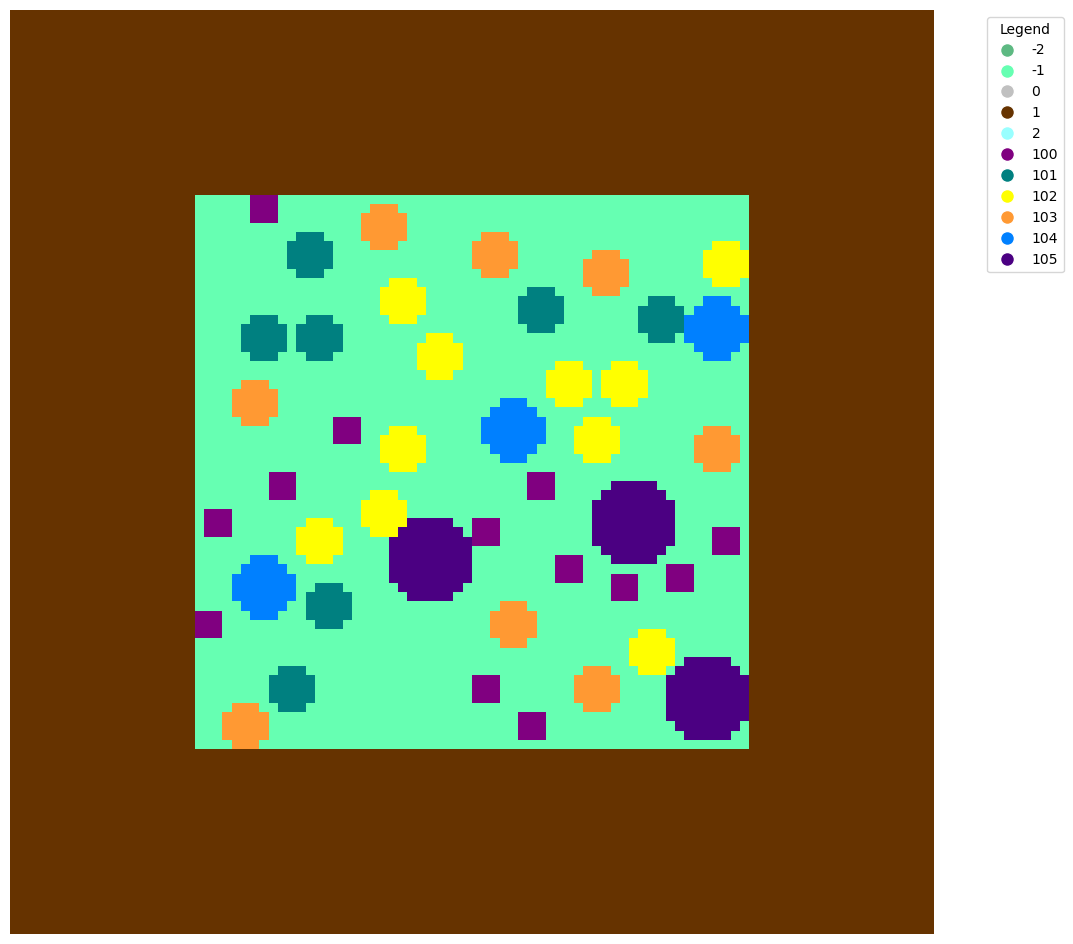

-42935


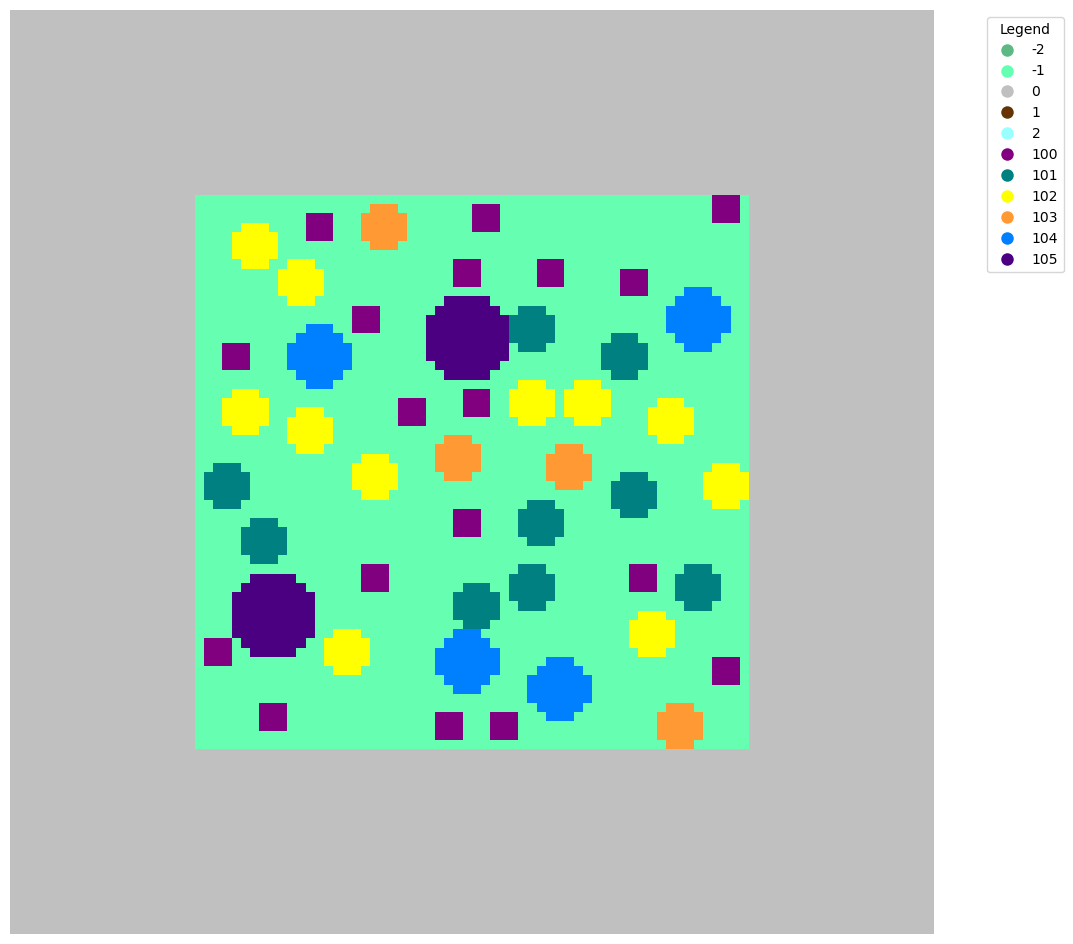

In [22]:
obs, info = eval_env1.reset(None, None)
total_reward = 0

for _ in range(1000):
    # Get action from the model
    action, _ = model.predict(obs)  # Get the predicted action
    obs, reward, done, trunacted, info = eval_env1.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    if done:
        eval_env1.render()
        break

print(total_reward)
obs, info = eval_env2.reset(None, None)

for _ in range(1000):
    # Get action from the model
    action, _ = model.predict(obs)  # Get the predicted action
    obs, reward, done, trunacted, info = eval_env2.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    if done:
        eval_env2.render()
        break

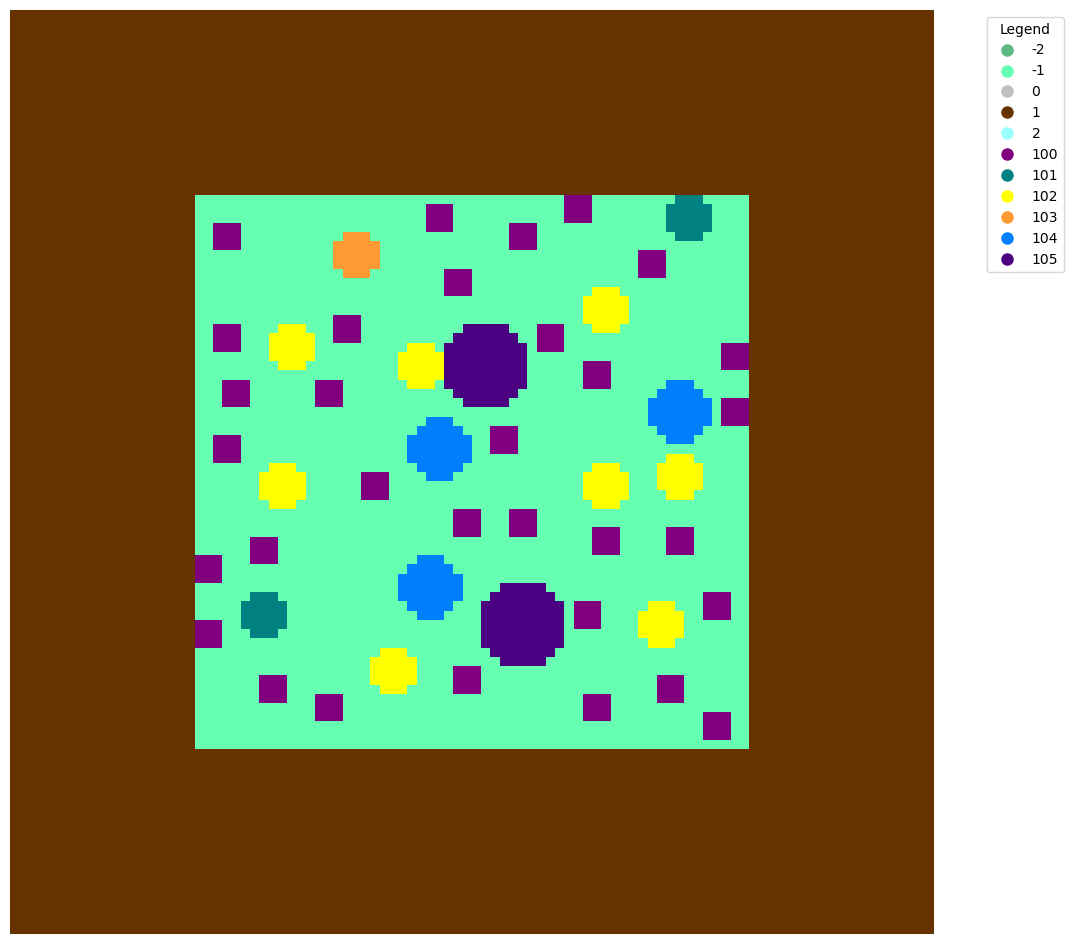

-32442


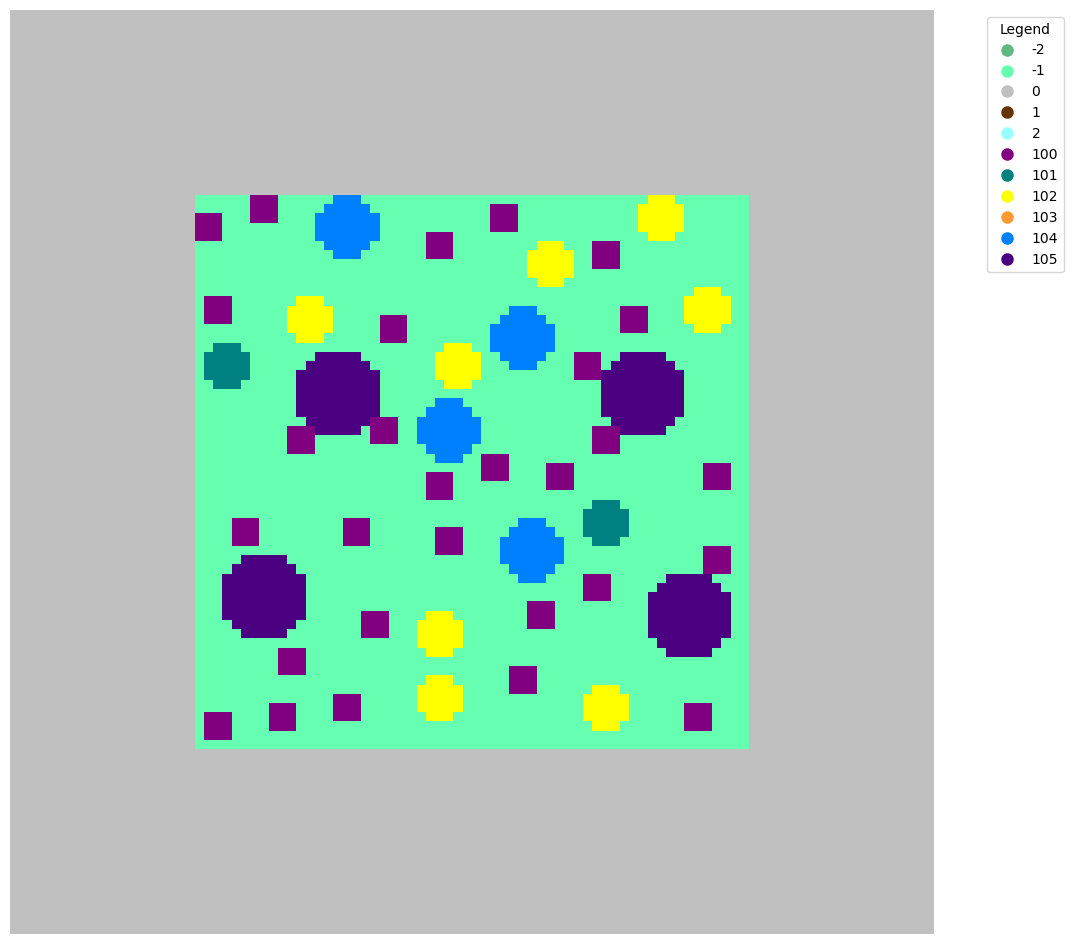

In [20]:
obs, info = eval_env1.reset(None, None)
total_reward = 0

for _ in range(1000):
    # Get action from the model
    action, _ = model1.predict(obs)  # Get the predicted action
    obs, reward, done, trunacted, info = eval_env1.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    if done:
        eval_env1.render()
        break

print(total_reward)
obs, info = eval_env2.reset(None, None)

for _ in range(1000):
    # Get action from the model
    action, _ = model1.predict(obs)  # Get the predicted action
    obs, reward, done, trunacted, info = eval_env2.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    if done:
        eval_env2.render()
        break

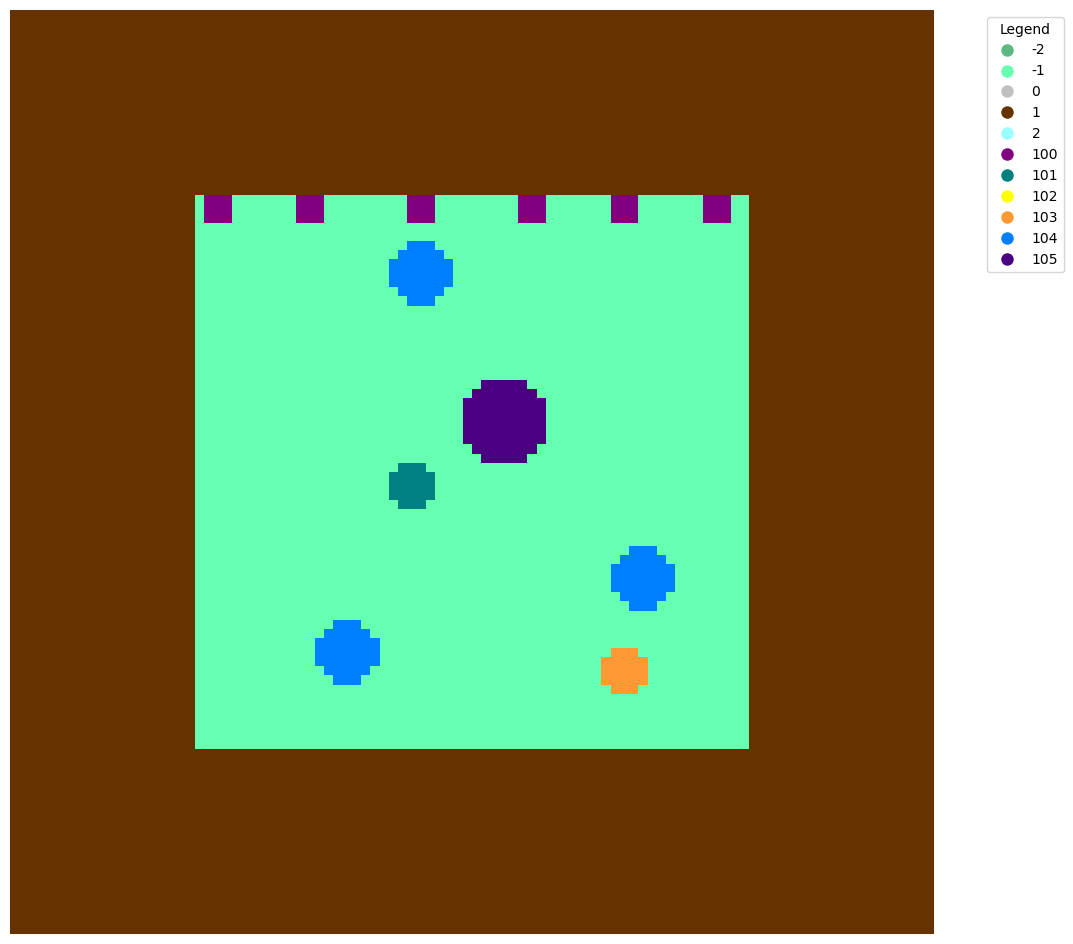

-148534


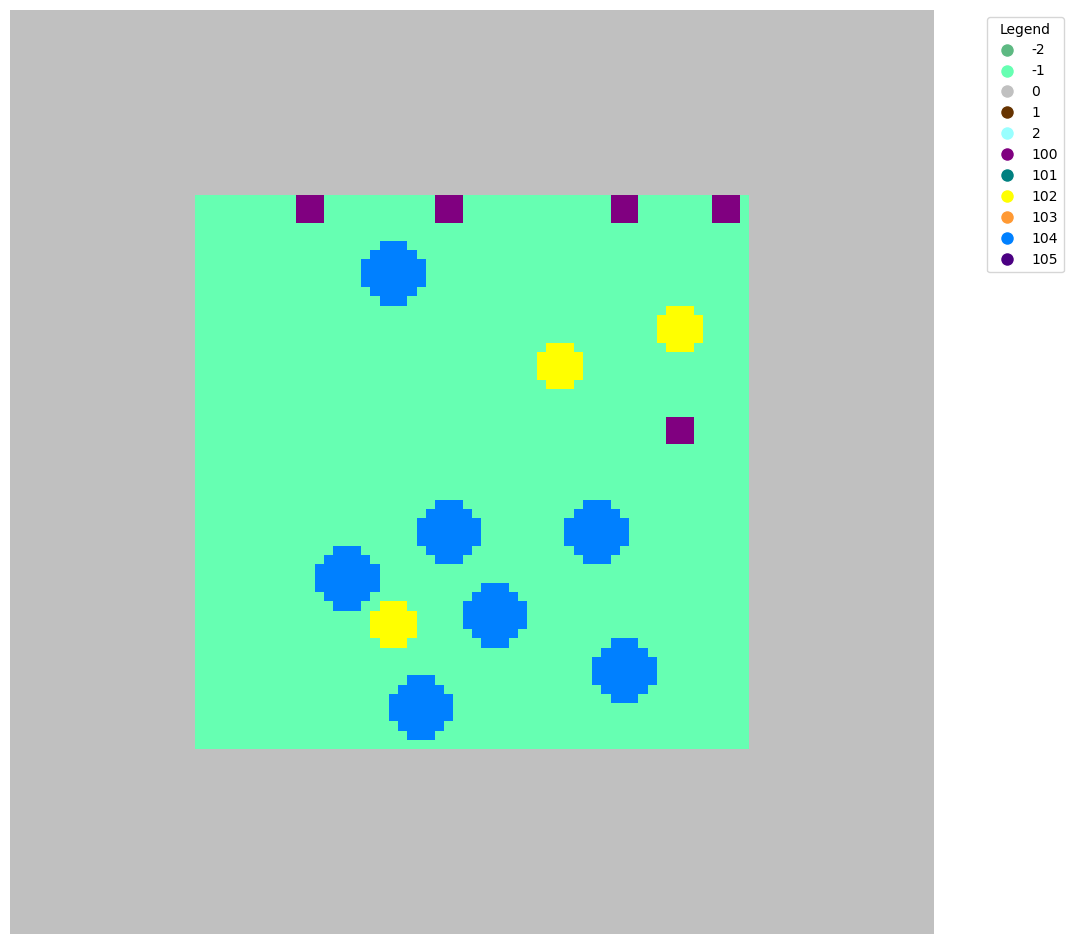

In [27]:
obs, info = eval_env1.reset(None, None)
total_reward = 0

for _ in range(5000):
    # Get action from the model
    action, _ = model2.predict(obs)  # Get the predicted action
    obs, reward, done, trunacted, info = eval_env1.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    if done:
        eval_env1.render()
        break

print(total_reward)
obs, info = eval_env2.reset(None, None)

for _ in range(5000):
    # Get action from the model
    action, _ = model2.predict(obs)  # Get the predicted action
    obs, reward, done, trunacted, info = eval_env2.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    if done:
        eval_env2.render()
        break

In [ ]:
from sb3_contrib.common.maskable.evaluation import evaluate_policy

max_runs = 1000
total_timesteps = max_runs* 30

model.learn(total_timesteps=total_timesteps, progress_bar=True, callback=reward_callback)
print(evaluate_policy(model, envs, n_eval_episodes=20, warn=False))


In [11]:
eval_env1 = customPlantingEnv(create_grid('square', 100, (60,60), 1, -1), [species1, species3, species5, species6], 1000, 1000)
eval_env2 = customPlantingEnv(create_grid('square', 100, (60,60), 0, -1), [species1, species3, species4, species5, species6], 1000, 1000)

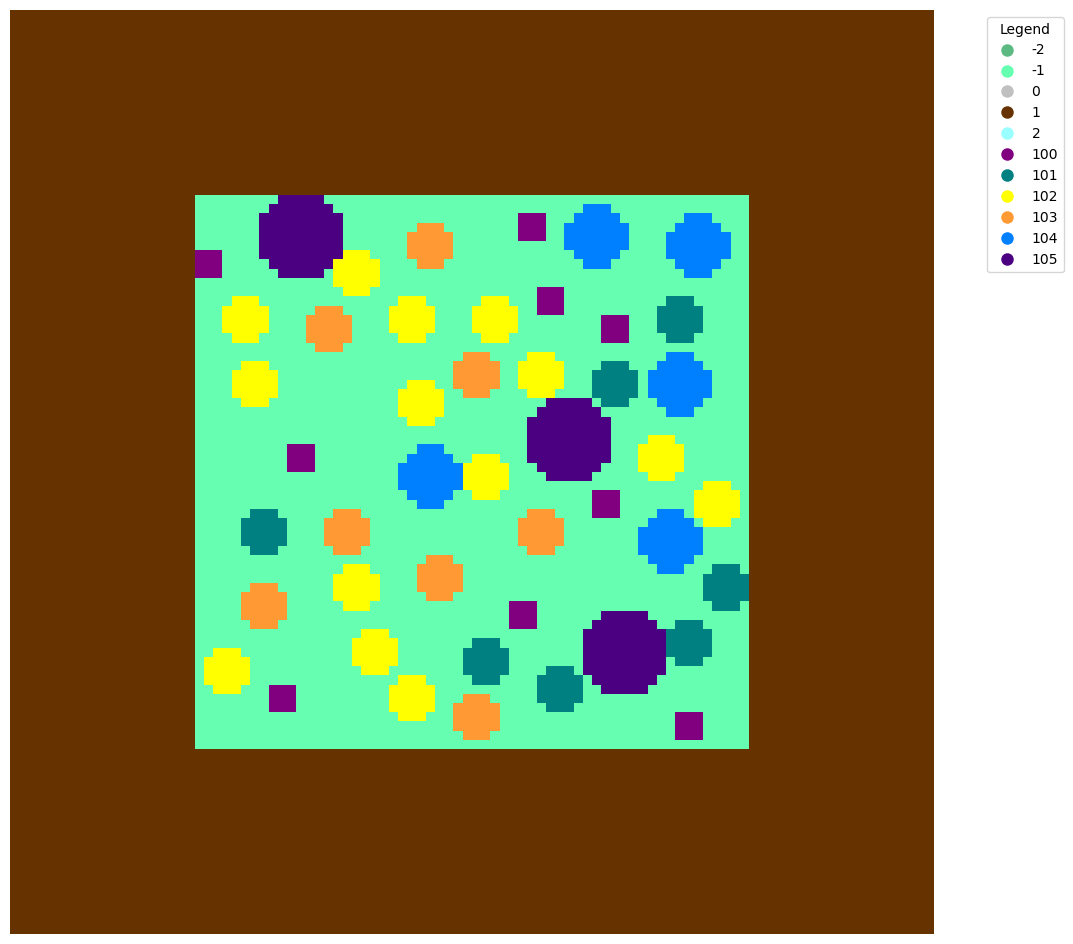

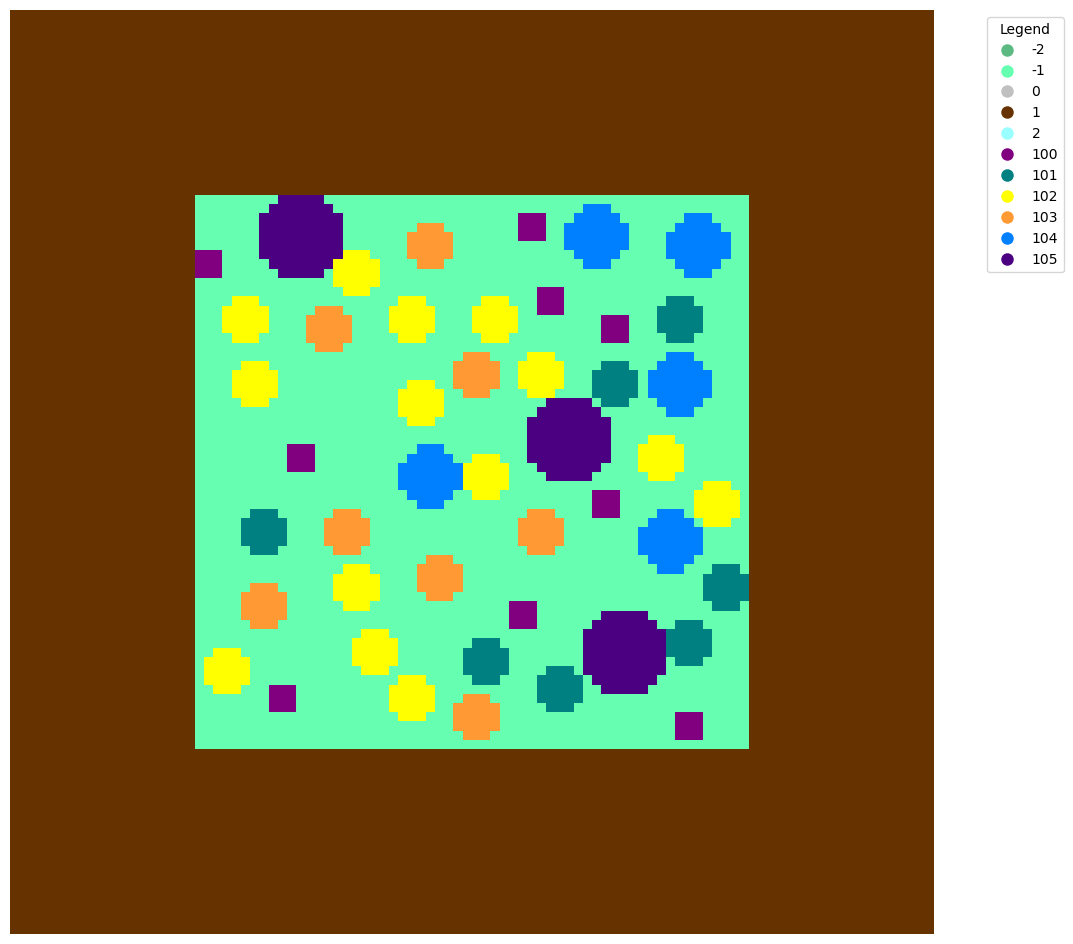

-40448


In [12]:
obs, info = eval_env1.reset(None, None)
total_reward = 0

for _ in range(1000):
    # Get action from the model
    action, _ = model.predict(obs)  # Get the predicted action
    obs, reward, done, trunacted, info = eval_env1.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    if done:
        eval_env1.render()
        break

eval_env1.render()
print(total_reward)

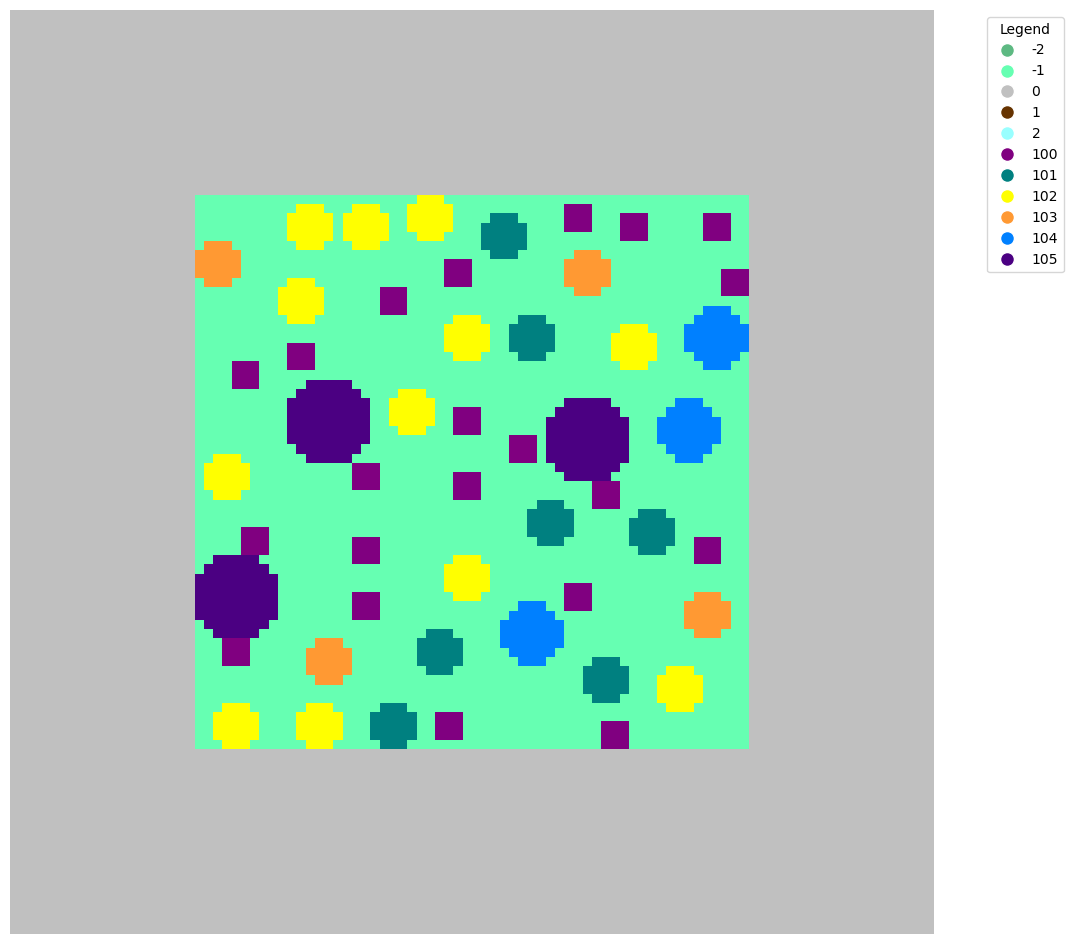

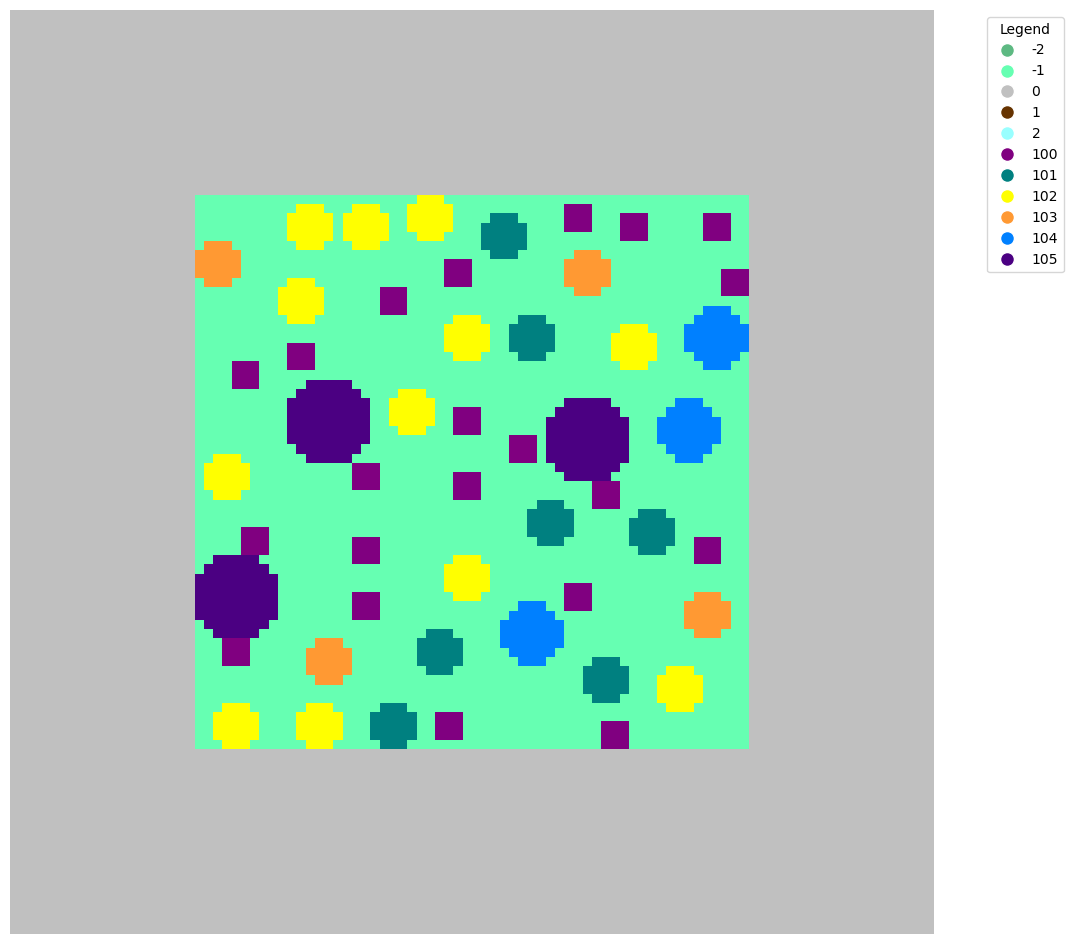

-39525


In [16]:
obs, info = eval_env2.reset(None, None)
total_reward = 0

for _ in range(1000):
    # Get action from the model
    action, _ = model.predict(obs)  # Get the predicted action
    obs, reward, done, trunacted, info = eval_env2.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    if done:
        eval_env2.render()
        break

eval_env2.render()
print(total_reward)

In [14]:
obs, info = env.reset()
total_reward = 0

for _ in range(1000):
    # Get action from the model
    action, _ = model.predict(obs)  # Get the predicted action
    obs, reward, done, trunacted, info = env.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    if done:
        env.render()

env.render()
print(total_reward)

NameError: name 'env' is not defined

In [34]:
import numpy as np
from scipy.ndimage import distance_transform_edt

def calculate_distance_layers(grid):
    # Calculate the distance transform of the 1's from the nearest 0's
    distance_grid = distance_transform_edt(grid)
    
    # Set boundary (0s) back to 0 in the result, keeping distances only for 1s
    distance_grid[grid == 0] = 0
    
    # Floor the distance values to get integer distances
    distance_grid = np.floor(distance_grid).astype(int)
    
    return distance_grid

# Example usage
grid = np.array([
    [0, 0, 0, 0, 0, 0],
    [-1, 1, 1, 1, 0, 0],
    [-1, 1, 1, 1, 1, 0],
    [-1, 1, 1, 1, 1, 0],
    [0, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0]
])

distance_grid = calculate_distance_layers(grid)
print(distance_grid)


[[0 0 0 0 0 0]
 [1 1 1 1 0 0]
 [2 2 2 1 1 0]
 [1 1 1 1 1 0]
 [0 0 1 1 0 0]
 [0 0 0 0 0 0]]


c:\Users\cheng\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
